## Is it Koyo? 

June 18, 2024 

By Natalie Ho 

After working on fast.ai's first module on classifying birds vs. dogs, I decided to see if I could make a module of my own identifying my friends, Koyo and Mitchell! 

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -U duckduckgo_search
    !pip install fastai
    !pip install fastbook

     |████████████████████████████████| 5.0 MB 6.7 MB/s            
     |████████████████████████████████| 97 kB 4.6 MB/s             
     |████████████████████████████████| 75 kB 2.9 MB/s             
     |████████████████████████████████| 74 kB 2.1 MB/s             
     |████████████████████████████████| 57 kB 3.9 MB/s             
     |████████████████████████████████| 2.8 MB 62.2 MB/s            
  Attempting uninstall: lxml
    Found existing installation: lxml 4.8.0
    Uninstalling lxml-4.8.0:
      Successfully uninstalled lxml-4.8.0
  Attempting uninstall: click
    Found existing installation: click 8.0.3
    Uninstalling click-8.0.3:
      Successfully uninstalled click-8.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.2.3 requires typing-extensions<4.0.0.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.1.1 which i

## Step 1: Download images of Koyo

In [3]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

In [ ]:
'''
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)


im = Image.open(dest)
im.to_thumb(256,256)
'''

Opening a picture of Koyo using Pillow's Image class. 

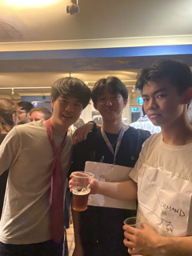

In [4]:
import pandas as pd
from PIL import Image

# Example of opening an image file
image_file_path = '/kaggle/input/new-images/Images/Koyo/IMG_4218 Small.jpeg'
image = Image.open(image_file_path).to_thumb(256,256)
image

## Step 2: Train our model

Used fast.ai's DataBlock to randomly select 80% of images to be the training set and 20% to be the validation set. This function shows a sample of 9 images that classifies if an image contains Mitchell or Koyo in it. 

**Challenges**
* Ran into an UnidentifiedImageError multiple times. I realized that I had to convert some images from HEIC into JPG. But even that wasn't enough! I had to compress all the images to avoid this error. 
* At first I had uploaded two separate folders of images. I realized I had to put the two Koyo and Mitchell subfolders into one larger Images folder as a complete dataset, so that DataBlock could be called and sort images of different categories. 

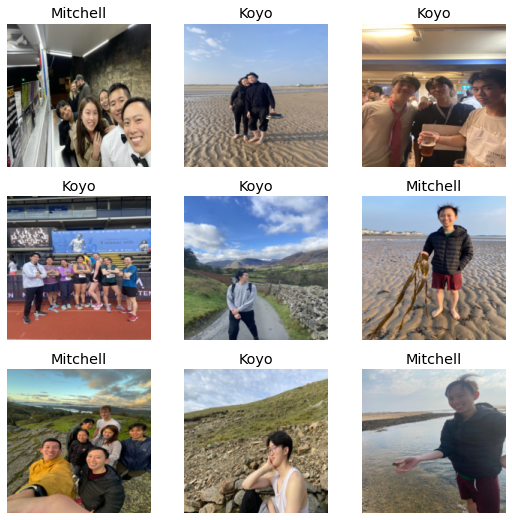

In [5]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders('/kaggle/input/new-images/Images/', bs=40)
#print(get_items)
dls.show_batch(max_n=9)


I thought one of the ways to fix the Unidentified image error was because the image was truncated, but turns out it was a different problem. 

Here I am fine tuning my model with resnet18, an image classification set pre-trained on ImageNet dataset. 

In [6]:
!pip install pillow

from PIL import ImageFile

#ImageFile.LOAD_TRUNCATED_IMAGES = True


learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.977937,4.476472,0.647059,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.849439,3.670967,0.647059,00:07
1,0.933344,2.001251,0.588235,00:07
2,0.757626,0.996445,0.411765,00:07


## Step 3: Test the model

In [7]:
test = '/kaggle/input/new-images/Images/Koyo/IMG_4594 Small.jpeg'
is_Koyo,_,probs = learn.predict(PILImage.create(test))

This is a: Koyo.
Probability it's a Koyo: 0.9927


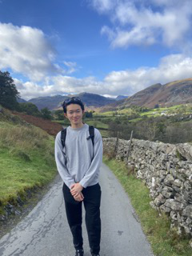

In [8]:
print(f"This is a: {is_Koyo}.")
print(f"Probability it's a Koyo: {probs[0]:.4f}")
image = Image.open(test).to_thumb(256,256)
image

Step 4: Export 

In [9]:
#export the architecture and trained parameters 
learn.export() 
#check that this export file exists with the ls method 
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [10]:
#inference = using a model for getting predictions 
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict(test)

('Koyo', tensor(0), tensor([0.9927, 0.0073]))

In [11]:
#use IPython widgets to create an upload button 
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [13]:
btn_upload = SimpleNamespace(data =[test])

#not sure what this actually does
img = PILImage.create(btn_upload.data[-1])

In [14]:
#display image passed into upload 
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [15]:
#get predictions 
pred,pred_idx,probs = learn_inf.predict(img)

#use Label to display prediction 
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]: .04f}'
lbl_pred

Label(value='Prediction: Koyo; Probability:  0.9927')

In [16]:
#create the classify button 
button_run = widgets.Button(description='Go!')
button_run

Button(description='Go!', style=ButtonStyle())

In [20]:
#create a click event handler, which calls the function when pressed 'Go!'
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

button_run.on_click(on_click_classify)

In [21]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Choose your player!'), btn_upload, button_run, out_pl, lbl_pred])



In [22]:
#Use Voila to turn notebook into a web app 
!pip install voila 
!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 5.5 MB 6.1 MB/s            
     |████████████████████████████████| 347 kB 51.2 MB/s            
     |████████████████████████████████| 89 kB 5.0 MB/s             
     |████████████████████████████████| 290 kB 60.8 MB/s            
     |████████████████████████████████| 77 kB 3.5 MB/s             
     |████████████████████████████████| 47 kB 3.3 MB/s             
  Attempting uninstall: jupyter-core
    Found existing installation: jupyter-core 4.9.1
    Uninstalling jupyter-core-4.9.1:
      Successfully uninstalled jupyter-core-4.9.1
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.1.3
    Uninstalling nbformat-5.1.3:
      Successfully uninstalled nbformat-5.1.3
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.3.0
    Uninstallin